In [1]:
# this notebook focuses on trying out different approaches to removing the background from the set of snapshots extracted from the car images

!pip install rembg
!pip install onnxruntime

!pip install opencv-python matplotlib torch torchvision numpy Pillow
!pip install git+https://github.com/facebookresearch/segment-anything.git

!pip install ultralytics

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-evx4armu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-evx4armu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36601 sha256=069535c6909409043cb5deee16356e139c5d393d413e59ba559ccd5207670315
  Stored in directory: /tmp/pip-ephem-wheel-cache-6l2cdco7/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


NOTE: Before running this code, make sure you have installed the required packages:
pip install opencv-python matplotlib torch torchvision numpy Pillow
pip install git+https://github.com/facebookresearch/segment-anything.git
Running both approaches for comparison...


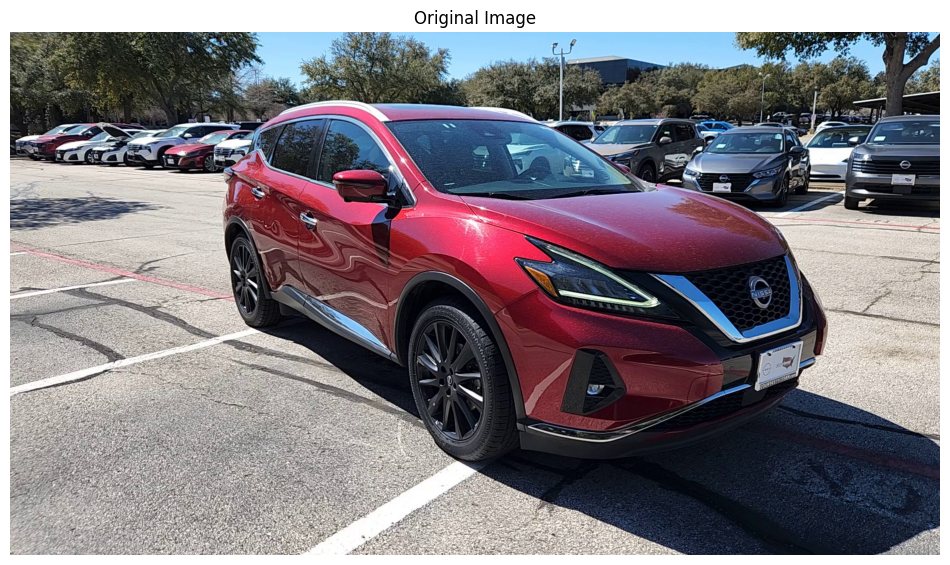

Running Segment Anything Model (SAM)...


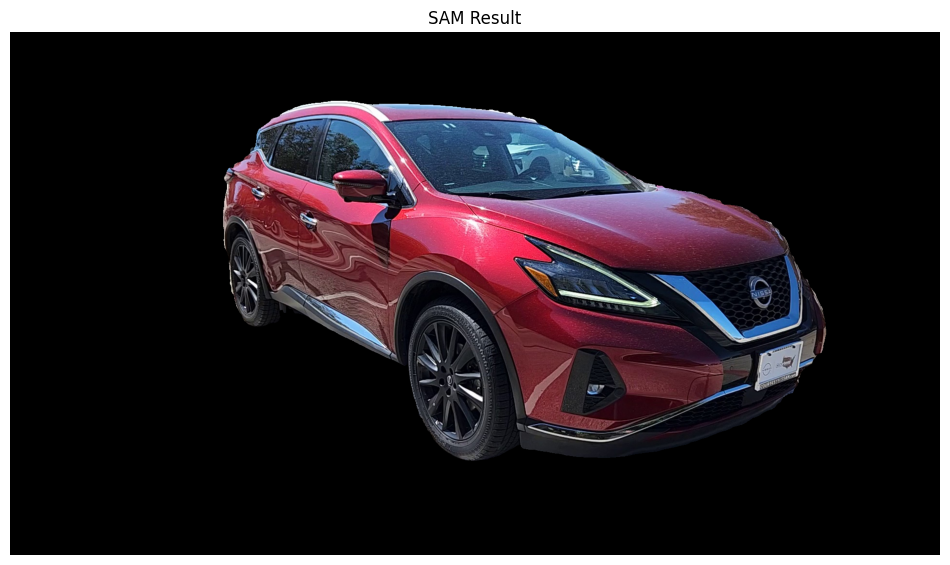

Results saved as 'sam_result.png' and 'sam_transparent.png'
Running DeepLabV3 semantic segmentation...


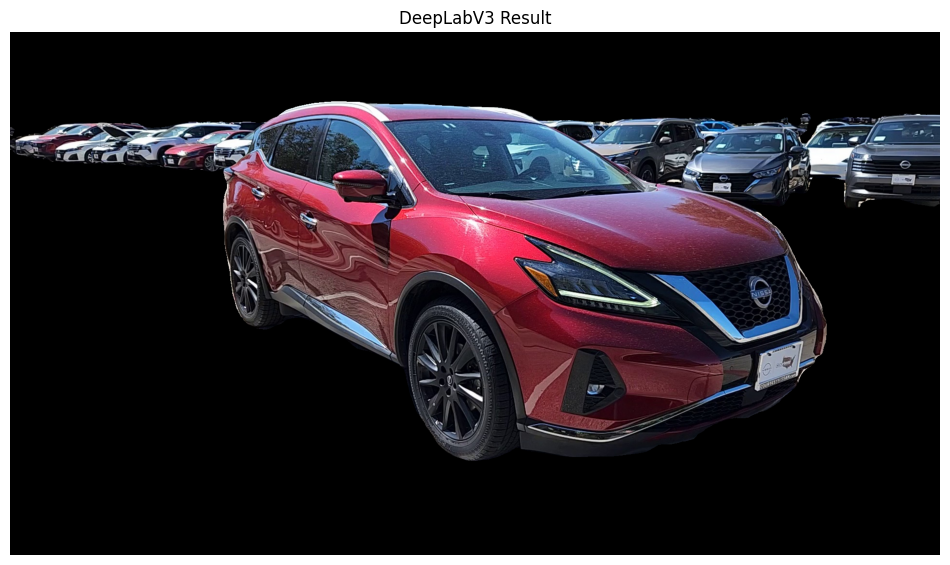

Results saved as 'deeplabv3_result.png' and 'deeplabv3_transparent.png'


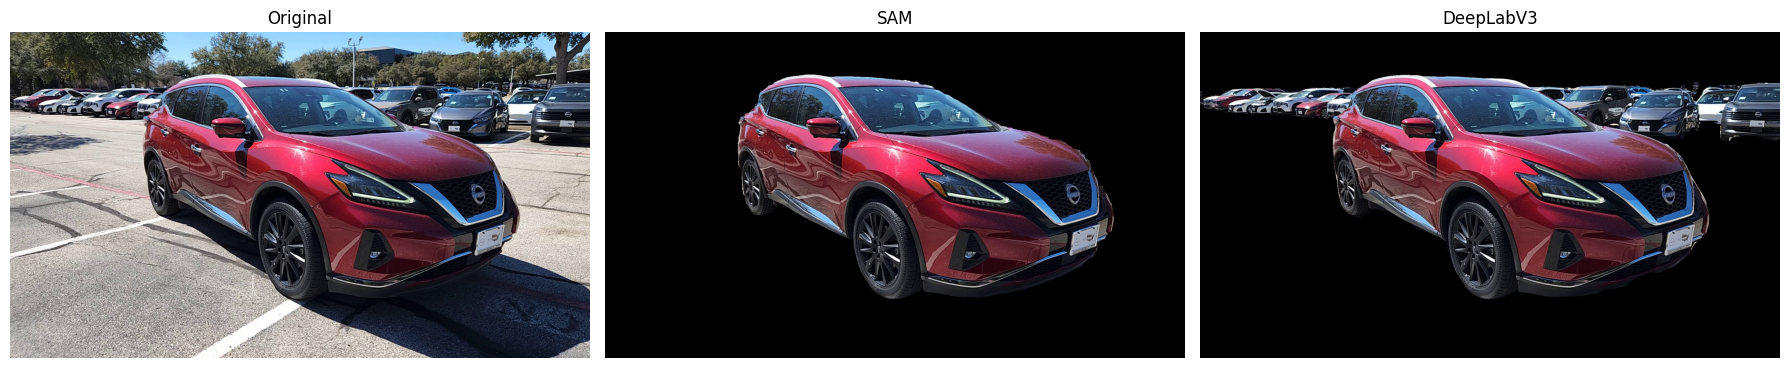

Comparison saved as 'comparison.png'


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import requests
from io import BytesIO

# Modify this path to where your image is stored
img_path = "../data/NissanMurano/frames/car000deg.jpg"  # Change this to your image path

# Display the image first
def display_original_image():
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

# Approach 1: Using Segment Anything Model (SAM) with automatic point selection
def segment_anything_model():
    print("Running Segment Anything Model (SAM)...")
    
    # Import the necessary libraries
    from segment_anything import sam_model_registry, SamPredictor
    
    # Download the SAM model if not already downloaded
    checkpoint_path = "../models/sam_vit_h_4b8939.pth"
    if not os.path.exists(checkpoint_path):
        print("Downloading SAM model weights...")
        url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
        response = requests.get(url)
        with open(checkpoint_path, 'wb') as f:
            f.write(response.content)
        print("Download complete!")
    
    # Set up the model
    model_type = "vit_h"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device=device)
    
    predictor = SamPredictor(sam)
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    predictor.set_image(img_rgb)
    
    # Select points in the center of the car (automatically)
    h, w = img.shape[:2]
    center_x, center_y = w // 2, h // 2
    
    # Create input points (center of the image where the car is)
    input_point = np.array([[center_x, center_y]])
    input_label = np.array([1])  # 1 means foreground
    
    # Get the mask from SAM
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )
    
    # Choose the mask with the highest score
    mask_idx = np.argmax(scores)
    mask = masks[mask_idx]
    
    # Apply the mask to the image
    result = img_rgb.copy()
    result[~mask] = [0, 0, 0]
    
    # Display the result
    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.title('SAM Result')
    plt.axis('off')
    plt.show()
    
    # Save the result
    result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./images/sam_result.png', result_bgr)
    
    # Create transparent version
    alpha = mask.astype(np.uint8) * 255
    result_rgba = np.concatenate([img_rgb, alpha[:, :, np.newaxis]], axis=2)
    cv2.imwrite('./images/sam_transparent.png', cv2.cvtColor(result_rgba, cv2.COLOR_RGBA2BGRA))
    
    print("Results saved as 'sam_result.png' and 'sam_transparent.png'")
    return mask

# Approach 2: Deep Learning with DeepLabV3
def deeplabv3_approach():
    print("Running DeepLabV3 semantic segmentation...")
    
    # Import the necessary libraries
    from torchvision import models, transforms
    import torch
    
    # Load the DeepLabV3 model pre-trained on COCO
    model = models.segmentation.deeplabv3_resnet101(weights="DEFAULT")
    model.eval()
    
    if torch.cuda.is_available():
        model.to('cuda')
    
    # Define the transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Load and transform the image
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
    
    # Do the inference
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    
    # The output has 21 channels - channel 7 corresponds to cars in COCO
    car_mask = output.argmax(0) == 7
    
    # Convert to numpy array
    car_mask = car_mask.cpu().numpy()
    
    # Apply the mask to the original image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create the result by masking
    result = img_rgb.copy()
    result[~car_mask] = [0, 0, 0]
    
    # Display the result
    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.title('DeepLabV3 Result')
    plt.axis('off')
    plt.show()
    
    # Save the result
    result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./images/deeplabv3_result.png', result_bgr)
    
    # Create transparent version
    alpha = car_mask.astype(np.uint8) * 255
    result_rgba = np.concatenate([img_rgb, alpha[:, :, np.newaxis]], axis=2)
    cv2.imwrite('./images/deeplabv3_transparent.png', cv2.cvtColor(result_rgba, cv2.COLOR_RGBA2BGRA))
    
    print("Results saved as 'deeplabv3_result.png' and 'deeplabv3_transparent.png'")
    return car_mask

# Function to compare the approaches
def compare_approaches():
    print("Running both approaches for comparison...")
    
    # Display original image
    display_original_image()
    
    # Run both approaches
    mask_sam = segment_anything_model()
    mask_deeplabv3 = deeplabv3_approach()
    
    # Display results for comparison
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original')
    
    result_sam = img_rgb.copy()
    result_sam[~mask_sam] = [0, 0, 0]
    axes[1].imshow(result_sam)
    axes[1].set_title('SAM')
    
    result_deeplabv3 = img_rgb.copy()
    result_deeplabv3[~mask_deeplabv3] = [0, 0, 0]
    axes[2].imshow(result_deeplabv3)
    axes[2].set_title('DeepLabV3')
    
    for ax in axes.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('./images/comparison.png')
    plt.show()
    
    print("Comparison saved as 'comparison.png'")


# You can run either one approach at a time:
# display_original_image()
# segment_anything_model()
# deeplabv3_approach()

# Or run both and compare:
# compare_approaches()

# Use this to run the full comparison
if __name__ == "__main__":
    print("NOTE: Before running this code, make sure you have installed the required packages:")
    print("pip install opencv-python matplotlib torch torchvision numpy Pillow")
    print("pip install git+https://github.com/facebookresearch/segment-anything.git")
    compare_approaches()